In [1]:
import re
import numpy as np
import io
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator
import string
import unicodedata
import spacy
import random
import utils as u

In [42]:
def get_char_lines(char):
    """ Get data for characters.
    """
    output = []
    if char == 'stark':
        starks = ['arya','sansa','ned','robb','catelyn','bran','rickon']
        output.extend(get_char_lines(starks))
    elif char == 'lannister':
        lannisters = ['jaime','cersei','tyrion','tywin','myrcella','tommen','joffrey']
        output.extend(get_char_lines(lannisters))
    else:
        print('Getting lines for', char)
        # data from https://github.com/shekharkoirala/Game_of_Thrones/tree/master/Data
        with open('final_data_s8.txt', 'r') as f:
            for line in f:
                if re.findall(r'(^'+char+r'.*:.*)', line, re.IGNORECASE):
                    output.append(line)
        f.close()
        print(char, 'has ', len(output), 'lines')
    return output

In [34]:
def cleandata_old(df):
    df['text_clean'] = df['text_raw'].apply(u.remove_backticks)
    # lowercase
    df['text_clean'] = df['text_clean'].apply(lambda x: x.lower())
    # # remove contractions
    df['text_clean'] = df['text_clean'].apply(u.expand_contractions)
    # # remove anything before :
    df['text_clean'] = df['text_clean'].apply(u.removetitle)
    # # remove anything in brackets
    df['text_clean'] = df['text_clean'].apply(u.removebrackets)
    # remove accented chars
    df['text_clean'] = df['text_clean'].apply(u.remove_accented_chars)
    # # lemmatize
    # df['text_clean'] = df['text_clean'].apply(u.lemmatize)
    # # remove special chars
    df['text_clean'] = df['text_clean'].apply(u.remove_special_chars)
    # remove stopwords
    df['text_clean'] = df['text_clean'].apply(u.remove_stopwords)
    return df

In [32]:
def cleandata(df):
    df['text_clean'] = df['text_raw'].apply(u.remove_backticks)
    # remove anything before :
    df['text_clean'] = df['text_raw'].apply(u.removetitle)
    # remove anything in brackets
    df['text_clean'] = df['text_clean'].apply(u.removebrackets)
    # remove accented chars
    df['text_clean'] = df['text_clean'].apply(u.remove_accented_chars)
    # remove contractions
    df['text_clean'] = df['text_clean'].apply(u.expand_contractions)
    # lemmatize
    print('Lemmatizing...')
    #df['text_clean'] = df['text_clean'].apply(lemmatize)
    # lowercase
    df['text_clean'] = df['text_clean'].apply(lambda x: x.lower())
    # remove special chars
    df['text_clean'] = df['text_clean'].apply(u.remove_special_chars)
    # remove stopwords
    df['text_clean'] = df['text_clean'].apply(u.remove_stopwords)
    return df

Getting data...
Getting lines for arya
arya has  776 lines
Cleaning data...
Lemmatizing...


[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading 

                                                                                                                                                                                                text_raw                                                                                         text_clean
0                                                                                                                                                                           ARYA (pushing BRAN): Move!\n                                                                                               move
1                                                                                                                                                                               ARYA: Where’s the Imp?\n                                                                                         wheres imp
2                                                                                                   

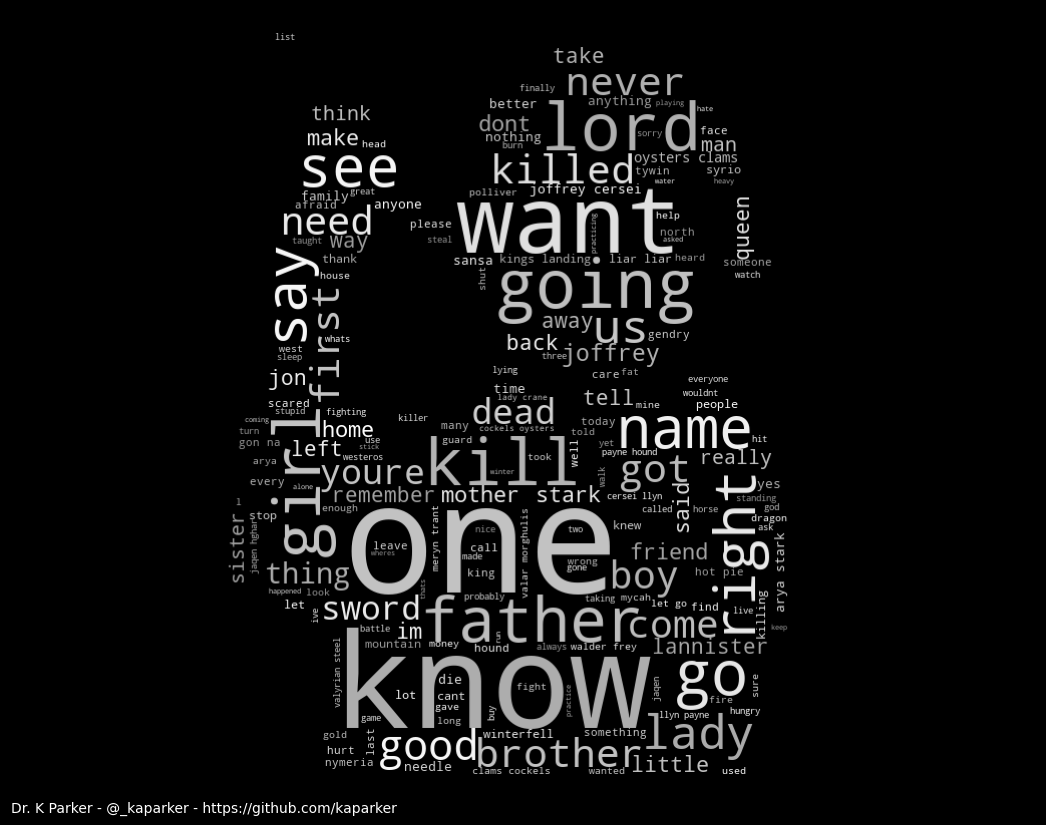

In [46]:
# arya image
# https://vignette.wikia.nocookie.net/gameofthrones/images/c/c5/AryawithNeedle.jpg/revision/latest?cb=20190404014817
runwordcloud('arya')

In [4]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

In [44]:
def runwordcloud(character, data_only=False):

    # based on example
    # https://github.com/keyonvafa/inaugural-wordclouds/blob/master/create_wordclouds.py

    # get data and clean
    print('Getting data...')
    df = pd.DataFrame(get_char_lines(character), columns=['text_raw'])

    print('Cleaning data...')
    df = cleandata(df)
    print(df.head(25).to_string())

    print('Number of words', df['text_clean'].apply(lambda x: len(x.split(' '))).sum())

    if data_only:
        return df
    # import image
    char_mask = np.array(Image.open("images/"+character+"_mask_white_bkg.jpeg"))
    image_colors = ImageColorGenerator(char_mask)
    # generate wordcloud
    print('Generating word cloud....')
    wc = WordCloud(background_color="black", max_words=200, width=400, height=400, #contour_width=3, contour_color='white',
    mask=char_mask, random_state=1).generate(' '.join(df['text_clean']))

    print('Making plot')
    plt.figure(figsize=(20,10))
    ypos = 800
    if character == 'lannister':
        ypos = 1500

    if character == 'stark':
        ypos = 1000

    plt.style.use('dark_background')
    plt.imshow(wc.recolor(color_func=grey_color_func))

    # use image colours with white background
    #plt.imshow(wc.recolor(color_func=image_colors))

    plt.text(0, ypos, "Dr. K Parker - @_kaparker - https://github.com/kaparker")
    plt.axis("off")
    plt.savefig('output/wordcloud_'+character+'_black_bkg.png', dpi=200)

In [45]:
df = runwordcloud('arya', True)

Getting data...
Getting lines for arya
arya has  776 lines
Cleaning data...
Lemmatizing...


[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading 

                                                                                                                                                                                                text_raw                                                                                         text_clean
0                                                                                                                                                                           ARYA (pushing BRAN): Move!\n                                                                                               move
1                                                                                                                                                                               ARYA: Where’s the Imp?\n                                                                                         wheres imp
2                                                                                                   

[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading 